In [198]:
import pandas as pd
from pandas import DataFrame
import os.path
import matplotlib.pyplot as plt
from pylab import *
import doctest

In [199]:
def download_file(file_name: str, url: str) -> None:
    """ Download the big csv data file from link if not in the project path

    :param file_name: file name
    :return: None
    >>> if os.path.exists('data/wa_ev_registrations_public.csv')
    ...     os.remove('data/wa_ev_registrations_public.csv')
    >>> download_file('wa_ev_registrations_public', 'https://www.atlasevhub.com/public/dmv/wa_ev_registrations_public.csv')
    >>> os.path.exists('data/wa_ev_registrations_public.csv')
    True
    >>> if os.path.exists('data/wa_test.csv')
    ...     os.remove('data/wa_test.csv')
    >>> download_file('wa_ev_registrations_public', 'https://www.atlasevhub.com/public/dmv/wa_ev_registrations_public.csv')
    >>> os.path.exists('data/wa_test.csv')
    False
    """
    if not os.path.exists('data/{}.csv'.format(file_name)):
        import requests
        file = requests.get(url)
        print(file)
        with open('data/{}.csv'.format(file_name), 'wb') as text:
            text.write(file.content)

In [200]:
download_file('wa_ev_registrations_public', 'https://www.atlasevhub.com/public/dmv/wa_ev_registrations_public.csv')
download_file('ny_ev_registrations_public', 'https://www.atlasevhub.com/public/dmv/ny_ev_registrations_public.csv')
download_file('tx_ev_registrations_public', 'https://www.atlasevhub.com/public/dmv/tx_ev_registrations_public.csv')
download_file('ev_stations_v1', 'https://www.kaggle.com/datasets/prasertk/electric-vehicle-charging-stations-in-usa/download')
download_file('uszips.csv', 'https://simplemaps.com/static/data/us-zips/1.80/basic/simplemaps_uszips_basicv1.80.zip')

# Hypothesis 1:
# What is the difference in sales between different brands of new energy vehicles？

### In hypothesis 1, we study the distribution of vehicle brands in New York, Texas and Washington in 2020-2022, so the variables we need are the registration time of the car, the brand of the car, and use some visualizations for data presentation , which facilitates analysis.

New York State

In [201]:
newyork_data = pd.read_csv('data/ny_ev_registrations_public.csv')
newyork_data_df = DataFrame(newyork_data)

In [202]:
len(newyork_data_df)

2910288

In [203]:
newyork_data_df.head(5)

,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,Technology
0,11797,2020-02-21,5YJXCBE2,39,NY DATA.NY.GOV (4/2/2020),J,2020-12-19,NY,Tesla Model X,BEV
1,11215,2018-09-21,5YJXCBE2,39,NY DATA.NY.GOV (4/2/2020),J,2020-09-20,NY,Tesla Model X,BEV
2,11040,2018-12-03,5YJXCBE2,39,NY DATA.NY.GOV (4/2/2020),J,2021-01-08,NY,Tesla Model X,BEV
3,11215,2018-09-30,5YJXCBE2,39,NY DATA.NY.GOV (4/2/2020),J,2020-09-29,NY,Tesla Model X,BEV
4,11976,2018-09-11,5YJXCBE2,39,NY DATA.NY.GOV (4/2/2020),J,2020-08-09,NY,Tesla Model X,BEV


It can be seen from the initial data that in order to filter out the data for 2020-2022, it is necessary to filter from the 'Registration valid date' and count the same brands in the 'Vechicle name'.

In [204]:
def split_date_make(file, date_split_symbol, make_split_symbol, date_split_loc, make_split_loc, year_of_extraction):
    """
    The split_date_make function is to extract the year and brand from columns 'Registration valid date' and 'Vehicle name'.
    :param file: the initial data
    :param date_split_symbol: Year, month and day separators in 'Registration valid date'
    :param make_split_symbol: Car make and model separator in 'Vehicle name'
    :param date_split_loc: The location of the database we want to separate in 'Registration valid date'
    :param make_split_loc: The location of the database we want to separate in 'Vehicle name'
    :param year_of_extraction: The earliest year we want to extract
    :return: clean_file with two columns ('Date' and 'Make')

    >>> a = DataFrame(data =[[11797, '2020-02-21', '5YJXCBE2', 39, 'NY DATA.NY.GOV (4/2/2020)','J', '2020-12-19', 'NY', 'Tesla Model X', 'BEV']] ,columns=['ZIP Code', 'Registration Valid Date', 'VIN Prefix', 'DMV ID','DMV Snapshot', 'VIN Model Year', 'Registration Expiration Date','State', 'Vehicle Name', 'Technology'],index=[0] )
    >>> test = split_date_make(a, '-',' ',0,0,2020)
    >>> type(test)
    <class 'pandas.core.frame.DataFrame'>
    >>> test.columns
    Index(['Date', 'Make'], dtype='object')
    """
    file.insert(file.shape[1], 'Date',
                        file['Registration Valid Date'].str.split(date_split_symbol, expand=True)[date_split_loc])
    file.insert(file.shape[-1], 'Make',
                        file['Vehicle Name'].str.split(make_split_symbol, expand=True)[make_split_loc])
    file[['Date']] = file[['Date']].astype(int)
    file = file[file['Date'] >= year_of_extraction]
    clean_file = file[['Date', 'Make']]
    return clean_file

In [205]:
result_clean_file = split_date_make(newyork_data_df, '-',' ',0,0,2020)

In [206]:
result_clean_file.head(1)

,Date,Make
0,2020,Tesla


In [207]:
def my_autopct(pct):
    """ The my_autopct function is to extract the percentage which is larger than 1%.

    :param pct: pct statistics
    :return: the result which is larger than 1%
    """
    return ('%.1f%%' % pct) if pct > 1 else ''

In [208]:
def h2_EV_analyze(data_file, state_name):
    """
    The h2_EV_analyze function is to count different brands and show as a pie plot and bar plot.
    :param data_file: The clean file from the split_date_make function.
    :param state_name: The state name of the data we use.
    :return: A data frame that counting different brands, a pie plot and a bar plot according to the data frame.

    >>> a = DataFrame(data = [[2020 ,'Tesla'],[2020 ,'Tesla'],[2020 ,'Tesla']], columns= ['Date','Make'])
    >>> test = a[pd.notnull(a['Make'])].groupby(by='Make').count()
    >>> type(test)
    <class 'pandas.core.frame.DataFrame'>
    >>> for i in test.values:
    ...     print(i)
    [3]
    """
    clean_file_count = data_file[pd.notnull(data_file['Make'])].groupby(by='Make').count()
    clean_file_count.columns = ['Brand Count']
    sorted_clean_file_count = clean_file_count.sort_values('Brand Count',ascending= False)
    sorted_clean_file_count = sorted_clean_file_count.head(20)
    print(sorted_clean_file_count)
    sorted_clean_file_count.plot.pie(subplots=True, figsize=(17, 17), autopct=my_autopct,
                                 title=state_name + ' Pie Chart of Different Brands of Car',labeldistance=0.9,fontsize = 15)
    sorted_clean_file_count.plot.bar(figsize=(20, 10),
                                 title=state_name + ' Bar Chart of Different Brands of Car',fontsize = 30)


In [209]:
doctest.testmod()

TestResults(failed=0, attempted=8)

            Brand Count
Make                   
Tesla            508748
Toyota           237971
Chevrolet         99612
Ford              86004
Hyundai           76490
BMW               58396
Honda             35323
Nissan            29153
Volvo             20462
Kia               19050
Porsche           16786
Audi              16239
Chrysler          16020
Mitsubishi        13878
Subaru            12930
Jeep              12809
Mercedes           7389
Volkswagen         7110
GEM                6358
Smart              3848


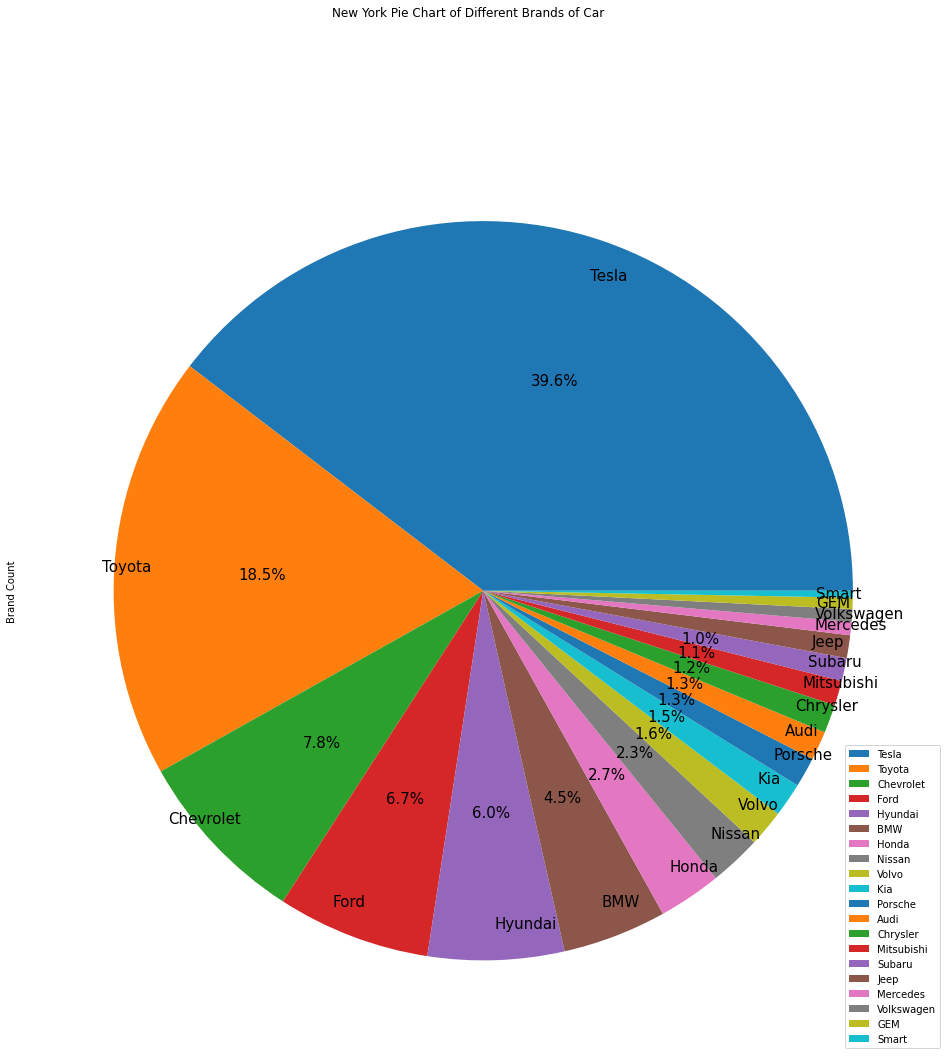

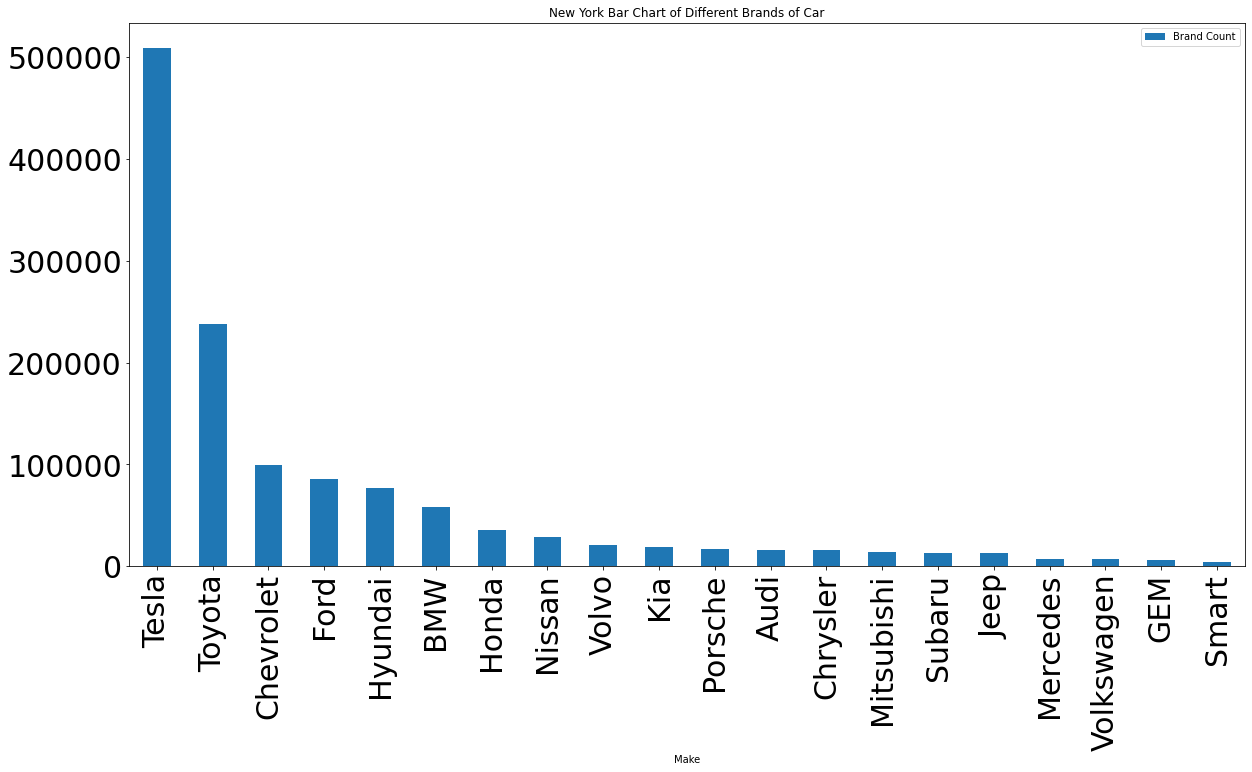

In [210]:
h2_EV_analyze(result_clean_file, 'New York')

We sort the vehicles according to the sales of different brands and take out the top 20 models for visualization. First, we take the as can be seen from the statistics and bar charts, Tesla outsells other brands of models by an absolute advantage. As we can see from the pie chart, Tesla sells more than one-third of all electric vehicles sold in New York State, followed by Toyota at 18.5 percent. After 2020, Tesla and Toyota’s electric vehicles will occupy more than half of the entire New York State market.

Texas State

In [211]:
texas_data = pd.read_csv('data/tx_ev_registrations_public.csv')
texas_data_df = DataFrame(texas_data)

In [212]:
len(texas_data_df)

1033202

In [213]:
texas_data_df.head(5)

,DMV ID,DMV Snapshot (Date),ZIP Code,Vehicle Name,Registration Valid Date,Registration Expiration Date
0,12,Registration Data from DFW Clean Cities (4/1/2...,75604,Tesla Model 3,2/11/2022,NaN
1,12,Registration Data from DFW Clean Cities (4/1/2...,78152,Tesla Model 3,1/7/2022,NaN
2,12,Registration Data from DFW Clean Cities (4/1/2...,77459,Tesla Model 3,3/7/2022,NaN
3,12,Registration Data from DFW Clean Cities (4/1/2...,78727,Tesla Model 3,7/16/2021,NaN
4,12,Registration Data from DFW Clean Cities (4/1/2...,77494,Tesla Model 3,12/1/2021,NaN


In [214]:
result_clean_file = split_date_make(texas_data_df, '/', ' ', 2, 0, 2020)

In [215]:
result_clean_file.head(10)

,Date,Make
0,2022,Tesla
1,2022,Tesla
2,2022,Tesla
3,2021,Tesla
4,2021,Tesla
5,2022,Tesla
6,2021,Tesla
7,2022,Tesla
8,2022,Tesla
9,2022,Tesla


            Brand Count
Make                   
Tesla            592750
Chevrolet         88997
BMW               64030
Ford              47869
Nissan            45791
Toyota            30130
Chrysler          24614
Porsche           21208
Audi              19767
Volvo             16858
Jeep              13000
Honda             10323
Kia                9914
Volkswagen         8837
Fiat               6439
Mitsubishi         4499
Mercedes           4079
Lincoln            3931
Mini               3324
Cadillac           3163


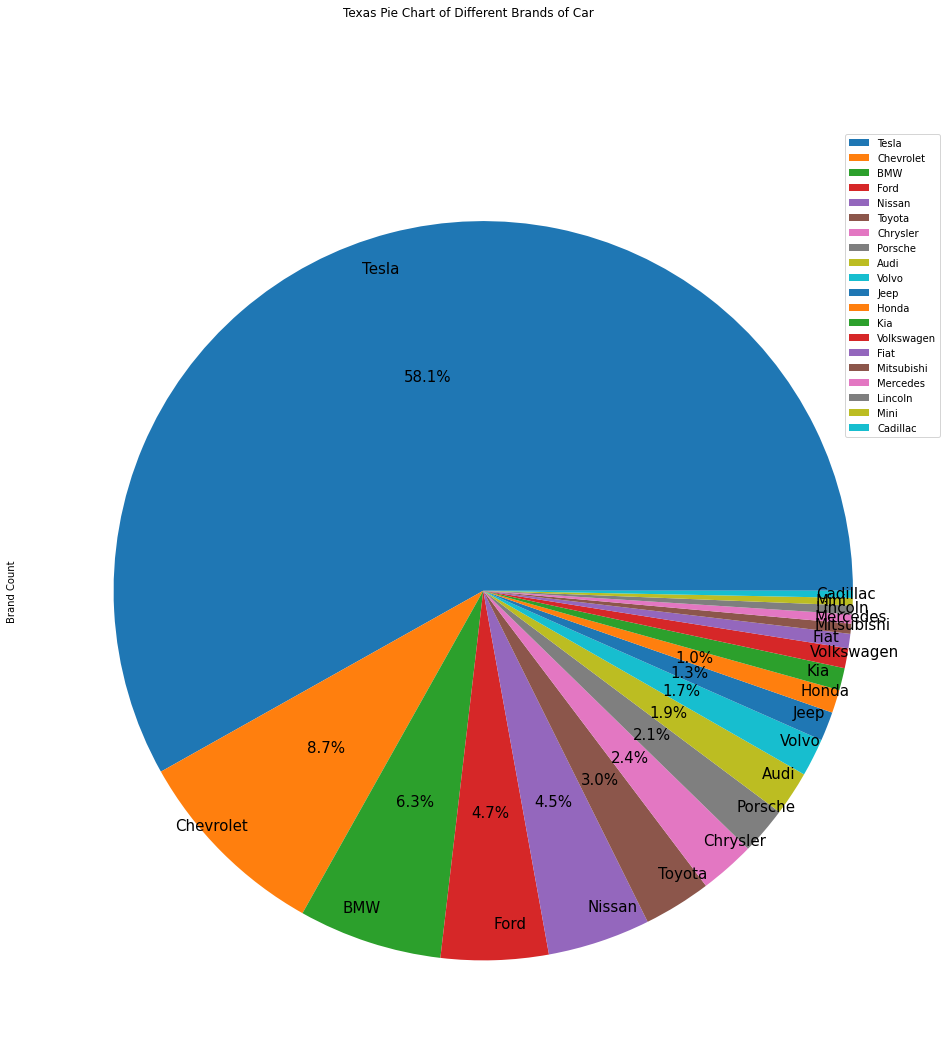

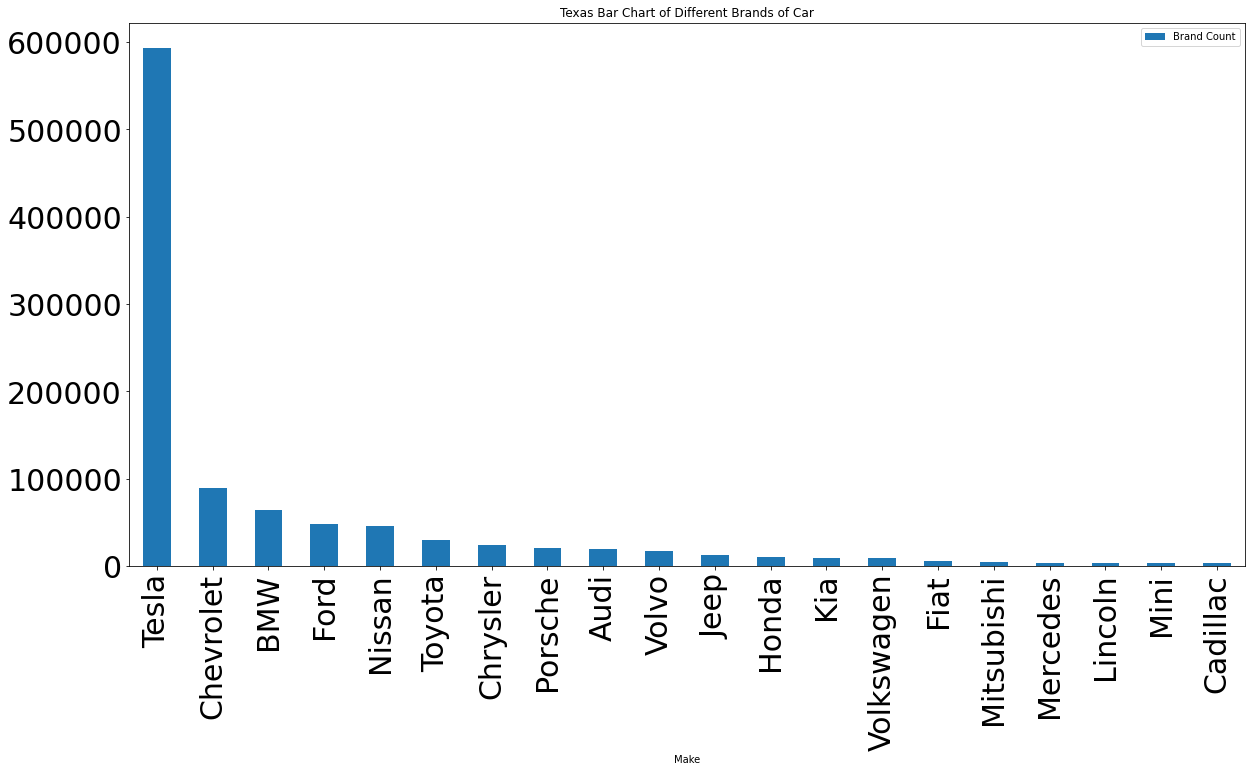

In [216]:
h2_EV_analyze(result_clean_file, 'Texas')

First, as can be seen from the bar chart, Tesla's advantage is even more obvious than New York State, far exceeding the sales of other brands. From the pie chart, it can be seen that Tesla alone occupies the entire Texas electric vehicle. 57.4% of sales, and all other models combined are lower than Tesla's sales.

Washington State

In [217]:
washington_data = pd.read_csv('data/wa_ev_registrations_public.csv',low_memory = False)
washington_data_df = DataFrame(washington_data)

In [218]:
len(washington_data_df)

2364838

In [219]:
washington_data_df.head(5)

,Vehicle ID,ZIP Code,Registration Valid Date,VIN Prefix,VIN Model Year,DMV ID,DMV ID Complete,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name,Technology
0,WA-047-134958694,98012,2022-03-16,5YJ3E1EC,M,47,WA47,WA DMV Direct (3/16/2022),NaN,WA,ZIP Code,Tesla Model 3,BEV
1,WA-047-276610085,98664,2022-03-16,JA4J24A5,J,47,WA47,WA DMV Direct (3/16/2022),NaN,WA,ZIP Code,Mitsubishi Outlander Plug In,PHEV
2,WA-047-192782285,98020,2022-03-16,7SAYGAEE,N,47,WA47,WA DMV Direct (3/16/2022),NaN,WA,ZIP Code,Tesla Model Y,BEV
3,WA-047-179410703,98029,2022-03-16,LPSED3KA,M,47,WA47,WA DMV Direct (3/16/2022),NaN,WA,ZIP Code,Polestar 2,BEV
4,WA-047-171474537,98004,2022-03-16,WP0AB2Y1,M,47,WA47,WA DMV Direct (3/16/2022),NaN,WA,ZIP Code,Porsche Taycan,BEV


In [220]:
result_clean_file = split_date_make(washington_data_df, '-', ' ', 0, 0, 2020)

In [221]:
result_clean_file.head(10)

,Date,Make
0,2022,Tesla
1,2022,Mitsubishi
2,2022,Tesla
3,2022,Polestar
4,2022,Porsche
5,2022,Tesla
6,2022,Tesla
7,2022,Tesla
8,2022,Kia
9,2022,Nissan


            Brand Count
Make                   
Tesla            742490
Nissan           309740
Chevrolet        232100
Ford             105005
Toyota            81653
BMW               80865
Kia               54565
Audi              33194
Volkswagen        30383
Chrysler          27628
Fiat              19890
Honda             18321
Volvo             17639
Mitsubishi        12234
Porsche           10855
Hyundai           10630
Mercedes           7136
Smart              6837
Mini               6554
Jaguar             4466


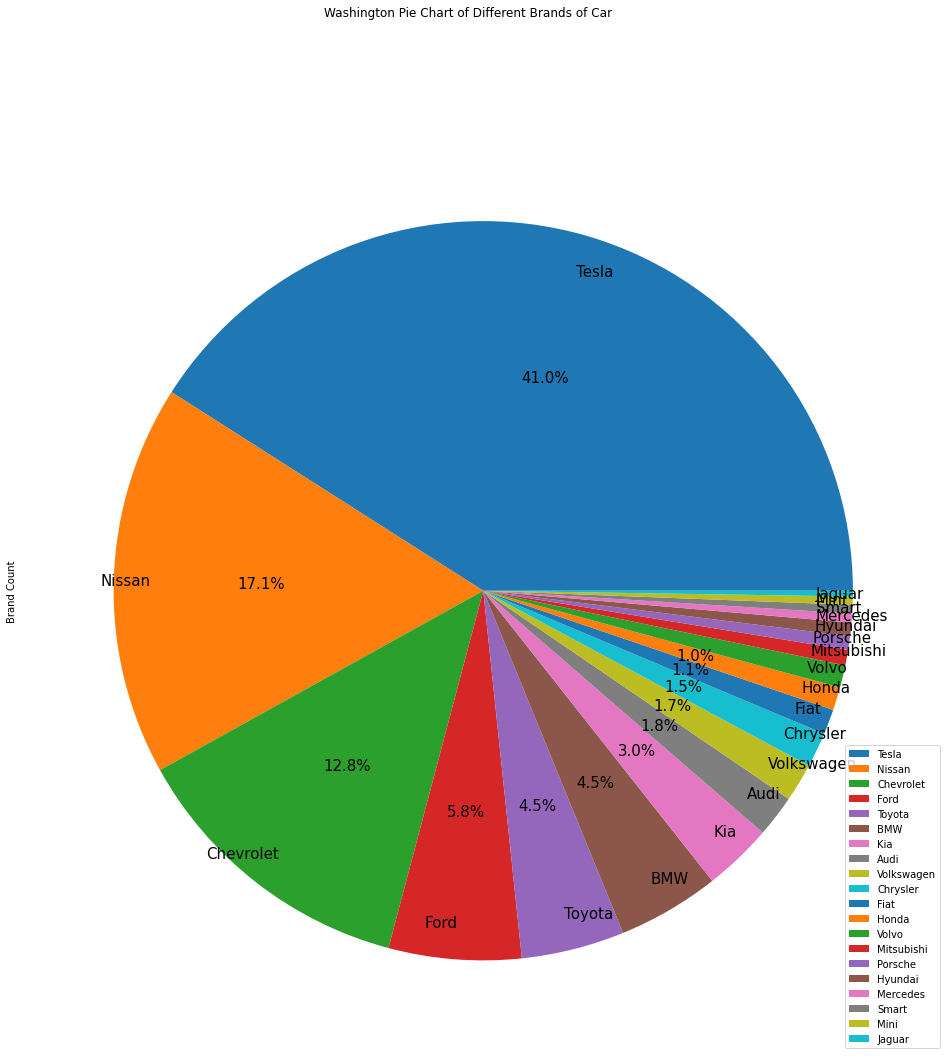

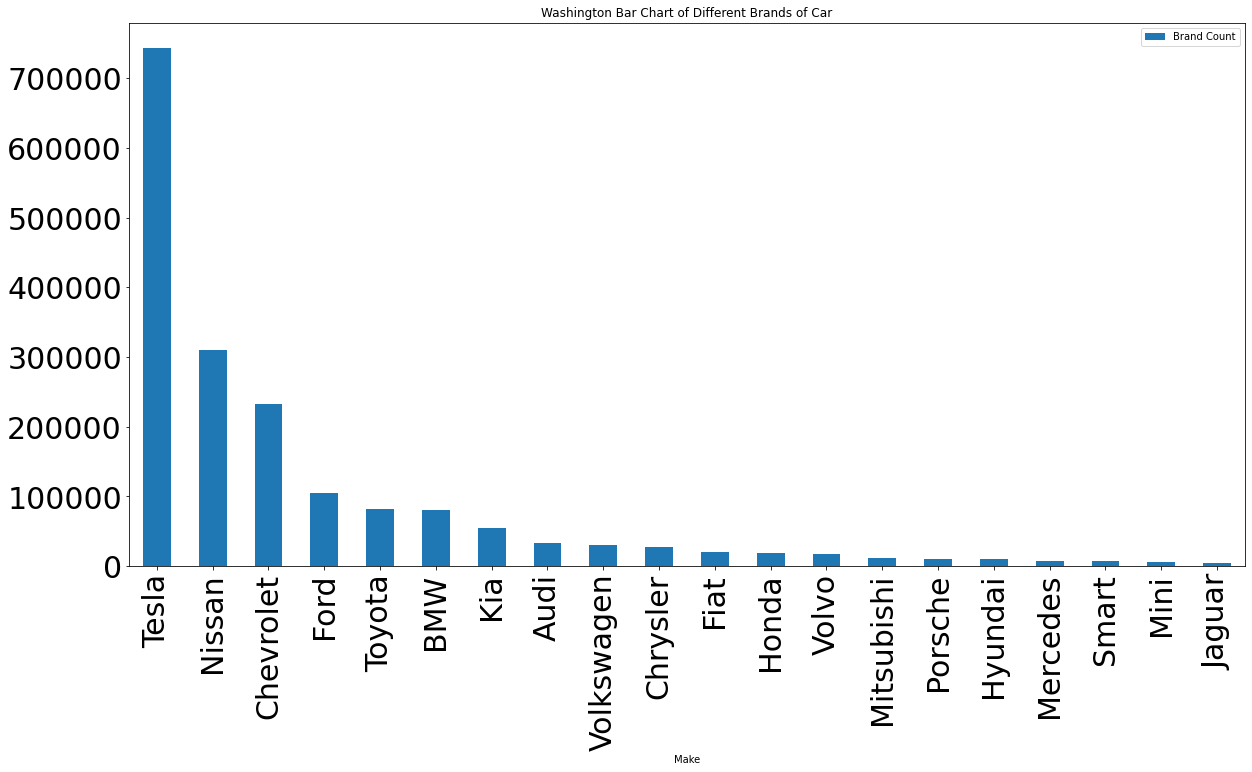

In [222]:
h2_EV_analyze(result_clean_file, 'Washington')

First, as you can see from the bar chart, Tesla remains the top seller, followed by Nissan and Chevrolet. And then for the pie chart, Tesla has 40.7% of the entire market, plus Nissan and Chevrolet, and it's around 70% of the market.

## Summary

Overall, Washington State has the most sales of electric cars, followed by New York State and Texas. In terms of sales of different brands, although Tesla occupies the largest market in each state, the state with the largest sales volume is Washington State, however. The state with the largest relative market share is Texas, which shows that although the sales of electric vehicles in Washington state are good, Tesla is the most popular in Texas.
Secondly, although Tesla is the most sold in every state, the advantage in Washington state is not as obvious as the other two states, which also shows that people in Washington state will have more different preferences when choosing electric vehicles.
Of course, there are many reasons for these differences, and these reasons require further analysis.